# Feature Engineering and Model Selection

### Load librarires

In [91]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [92]:
path = os.getcwd()
path = path.replace('modeling', 'resources')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = path+'/'+file
data = pd.read_csv(csv_path)

In [93]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### Apply cleaning and processing done in data preparation

In [94]:
data['SeniorCitizen']=data['SeniorCitizen'].map({0:'No', 1:'Yes'})
data['TotalCharges']=pd.to_numeric(data.TotalCharges, errors='coerce')
data.drop(data[data.TotalCharges.isna()].index, axis=0, inplace=True)
data.drop('customerID', axis=1, inplace=True)

### Data Overview

In [95]:
data.shape

(7032, 20)

In [96]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Strategies

#### Feature Engineering  strategy

There are a few strategies that we can try out in Feature Engineering. We will test a few base models with each of these to check the redundancy of certain features.
- The `PhoneService` might be redundant as the information is already captured in `MultipleLines`
- We will be using `One-Hot Encoding` to handle the categorical variables in the data. But some of the features (`InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`) contain the same value 'No Internet Service'. So while applying One-Hot Encoder this feature gets duplicated. We can therefore add a separate feature to show if the customer has 'No Internet Service' and set the value as 'No' in the other features.
- The `TotalCharges` feature is approximately equal to the product of `tenure` and `MonthlyCharges`. We can check how removing `TotalCharges` affects performance.
- We can also try using Tenure ranges instead of the default `tenure` feature

#### Dataset Balancing Strategy

We have also seen that the dataset is imbalanced and that only around 25% of the data contains Churners. We can therefore try an over sampling and under-sampling using SMOTEEN

#### Model Selection Strategy

We can use lazy predict as a base to evaluate the features with different models. Once we are satisfied with a set of features we can select a model and tune its hyperparameters.

### Feature Engineering - 1

One-Hot Encoding with all features intact

In [97]:
from sklearn.model_selection import train_test_split

X1 = data.copy().drop('Churn', axis=1)
y = data['Churn'].replace({'Yes':1, 'No': 0})
cat_columns = X1.select_dtypes(include='object').columns
num_columns = X1.select_dtypes(include='number').columns

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=1)

In [98]:
X_train1.shape

(5625, 19)

In [99]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

transformer = [('one-hot', OneHotEncoder(), cat_columns), # One-Hot Encode categorical columns
                       ('scaler', MinMaxScaler(), num_columns)] #Scale Numerical columns to lie between 0 and 1
preprocessor = ColumnTransformer(transformer)

X_train_OH1 = preprocessor.fit_transform(X_train1)
X_test_OH1 = preprocessor.transform(X_test1)

X_train_OH1 = pd.DataFrame(X_train_OH1)
X_test_OH1 = pd.DataFrame(X_test_OH1)

In [100]:
X_train_OH1.shape

(5625, 46)

In [101]:
X_train_OH1.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.01,0.00
1,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,...,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.92,0.02,0.15
2,0.00,1.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,...,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.99,0.72,0.77
3,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,...,1.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.82,0.84
4,0.00,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,...,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.27,0.00


In [102]:
from lazypredict.Supervised import LazyClassifier

lz_clf1 = LazyClassifier()

models1, predictions1 = lz_clf1.fit(X_train_OH1, X_test_OH1, y_train1, y_test1)

100%|██████████| 29/29 [00:09<00:00,  3.07it/s]


In [103]:
models1.sort_values(by='F1 Score', ascending=False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.80,0.70,0.70,0.79,0.21
LogisticRegression,0.80,0.71,0.71,0.79,0.27
LGBMClassifier,0.80,0.70,0.70,0.79,0.42
LinearSVC,0.79,0.71,0.71,0.79,0.74
SVC,0.80,0.70,0.70,0.79,0.87


We can see that quite a few of the models perform well. We can next try with a different feature engineering strategy.

### Feature Engineering - 2

Handle redundant features

In [104]:
phone_feats = ['PhoneService', 'MultipleLines']
internet_feats = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies']
data[phone_feats].value_counts()

PhoneService  MultipleLines   
Yes           No                  3385
              Yes                 2967
No            No phone service     680
Name: count, dtype: int64

In [105]:
data[internet_feats].value_counts()

InternetService  OnlineSecurity       OnlineBackup         DeviceProtection     TechSupport          StreamingTV          StreamingMovies    
No               No internet service  No internet service  No internet service  No internet service  No internet service  No internet service    1520
Fiber optic      No                   No                   No                   No                   No                   No                      399
DSL              No                   No                   No                   No                   No                   No                      294
Fiber optic      No                   No                   No                   No                   Yes                  Yes                     181
                                      Yes                  Yes                  No                   Yes                  Yes                     164
                                                                                                            

- We can drop `PhoneService` and One-Hot Encode `MultipleLines`. This will give us a column to show that the customer does not have phone service, and the details of `PhoneService` is automatically captured.

- Simillarly we can One-Hot Encode `InternetService`, which will give us a column that tells us whether a customer does not have Internet Service and then we can convert all 'No internet service in other columns to 'No'.

In [106]:
X2 = data.copy().drop('Churn', axis=1)
X2.drop('PhoneService', axis=1, inplace=True)
for col in internet_feats[1:]:
    X2[col] = X2[col].replace({'No internet service':'No'})

cat_columns = X2.select_dtypes(include='object').columns
num_columns = X2.select_dtypes(include='number').columns

In [107]:
X2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,No,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,No,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [108]:
X2[internet_feats].value_counts()

InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies
No               No              No            No                No           No           No                 1520
Fiber optic      No              No            No                No           No           No                  399
DSL              No              No            No                No           No           No                  294
Fiber optic      No              No            No                No           Yes          Yes                 181
                                 Yes           Yes               No           Yes          Yes                 164
                                                                                                              ... 
                 Yes             No            Yes               No           No           Yes                   9
                                                                 Yes          No        

In [109]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=1)

In [110]:
X_train2.shape

(5625, 18)

In [111]:
cat_columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [112]:
cat_columns1 = ['gender', 'PaymentMethod', 'MultipleLines', 'Contract'] # We can drop the first column for these features
cat_columns2 = cat_columns.drop(cat_columns1) #All these features have a 'No' value which we can target and make 0

In [113]:
drop_no = ['No'] * len(cat_columns2)

In [114]:
X_train2[cat_columns1].apply(pd.Series.unique)

gender                                              [Female, Male]
PaymentMethod    [Mailed check, Electronic check, Bank transfer...
MultipleLines                          [No, Yes, No phone service]
Contract                      [Month-to-month, Two year, One year]
dtype: object

In [115]:
X_train2[cat_columns2].apply(pd.Series.unique)

SeniorCitizen                    [No, Yes]
Partner                          [No, Yes]
Dependents                       [No, Yes]
InternetService     [No, DSL, Fiber optic]
OnlineSecurity                   [No, Yes]
OnlineBackup                     [No, Yes]
DeviceProtection                 [No, Yes]
TechSupport                      [No, Yes]
StreamingTV                      [No, Yes]
StreamingMovies                  [No, Yes]
PaperlessBilling                 [Yes, No]
dtype: object

In [116]:
transformer = [('OH1', OneHotEncoder(sparse_output=False, drop='first'), cat_columns1), # One-Hot Encode and drop first column
               ('OH2', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns2), # One-Hot Encode and drop 'No' value features
               ('scaler', MinMaxScaler(), num_columns)] # Scale Numerical columns to lie between 0 and 1
preprocessor = ColumnTransformer(transformer)

X_train_OH2 = preprocessor.fit_transform(X_train2)
X_test_OH2 = preprocessor.transform(X_test2)

X_train_OH2 = pd.DataFrame(X_train_OH2)
X_test_OH2 = pd.DataFrame(X_test_OH2)

In [117]:
X_train2.shape

(5625, 18)

In [118]:
X_train_OH2.shape

(5625, 23)

The transformation is correct. `PaymentMethod` has 4 categories, this gives becomes 3 new features as 1 is dropped. So this adds 2 new columns. Similarly, `MultipleLines` , `Contract` and `InternetService` adds 1 column each. So a total of 5 extra columns are added.

In [119]:
lz_clf2 = LazyClassifier()

models2, predictions2 = lz_clf2.fit(X_train_OH2, X_test_OH2, y_train2, y_test2)

100%|██████████| 29/29 [00:07<00:00,  4.00it/s]


In [120]:
models2.sort_values(by='F1 Score', ascending=False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.80,0.71,0.71,0.79,0.06
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.18
LinearSVC,0.79,0.71,0.71,0.79,0.36
CalibratedClassifierCV,0.79,0.70,0.70,0.79,1.29
LGBMClassifier,0.79,0.70,0.70,0.79,0.41


We can see that despite the transformed data having slightly lower times and improved performance for a few models, it did not have a large impact

We can select a few classifiers for the next sections comparion, to avoid oo much information

In [121]:
select_models = ['LogisticRegression', 'AdaBoostClassifier', 'LinearSVC']
models2.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.80,0.71,0.71,0.79,0.06
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.18
LinearSVC,0.79,0.71,0.71,0.79,0.36


### Feature Engineering - 3

Handle `tenure` : Change `tenure` to categories

In [122]:
X3 = data.copy().drop('Churn', axis=1)
X3.drop('PhoneService', axis=1, inplace=True)
for col in internet_feats[1:]:
    X3[col] = X3[col].replace({'No internet service':'No'})

tenure_bins=12
bin_size = int(X3['tenure'].max()/tenure_bins)
labels = ['{}-{}'.format(i, i+bin_size-1) for i in range(1,X3['tenure'].max(), bin_size)]
X3['tenure_range']=pd.cut(X3['tenure'], bins=range(1,X3['tenure'].max()+bin_size,bin_size), right=False, labels=labels)
X3.drop('tenure', axis=1, inplace=True)

cat_columns = X3.select_dtypes(exclude='number').columns
num_columns = X3.select_dtypes(include='number').columns

In [123]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.3, random_state=1)

cat_columns1 = ['gender', 'PaymentMethod', 'MultipleLines', 'Contract', 'tenure_range'] # We can drop the first column for these features
cat_columns2 = cat_columns.drop(cat_columns1) #All these features have a 'No' value which we can target and make 0
drop_no = ['No'] * len(cat_columns2)

transformer = [('OH1', OneHotEncoder(sparse_output=False, drop='first'), cat_columns1), # One-Hot Encode and drop first column
               ('OH2', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns2), # One-Hot Encode and drop 'No' value features
               ('scaler', MinMaxScaler(), num_columns)] # Scale Numerical columns to lie between 0 and 1
preprocessor = ColumnTransformer(transformer)

X_train_OH3 = preprocessor.fit_transform(X_train3)
X_test_OH3 = preprocessor.transform(X_test3)

X_train_OH3 = pd.DataFrame(X_train_OH3)
X_test_OH3 = pd.DataFrame(X_test_OH3)

In [124]:
lz_clf3 = LazyClassifier()

models3, predictions3 = lz_clf3.fit(X_train_OH3, X_test_OH3, y_train3, y_test3)

100%|██████████| 29/29 [00:06<00:00,  4.14it/s]


In [125]:
models3.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.80,0.71,0.71,0.79,0.04
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.14
LinearSVC,0.80,0.71,0.71,0.79,0.33


In [126]:
models3.sort_values(by='F1 Score', ascending=False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearDiscriminantAnalysis,0.80,0.72,0.72,0.80,0.17
LogisticRegression,0.80,0.71,0.71,0.79,0.04
LinearSVC,0.80,0.71,0.71,0.79,0.33
CalibratedClassifierCV,0.80,0.70,0.70,0.79,1.48
AdaBoostClassifier,0.80,0.71,0.71,0.79,0.14


In [127]:
models3.loc[select_models]-models2.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.00,-0.00,-0.00,0.00,-0.02
AdaBoostClassifier,-0.00,0.01,0.01,-0.00,-0.04
LinearSVC,0.01,-0.00,-0.00,0.00,-0.02


### Feature Engineering - 4

Removing `TotalCharges` as its approximately the same as `tenure` * `MonthlyCharges`. For this we will have to retain the `tenure`  feature.

In [128]:
X4 = data.copy().drop('Churn', axis=1)
X4.drop(['PhoneService', 'TotalCharges'], axis=1, inplace=True)
for col in internet_feats[1:]:
    X4[col] = X4[col].replace({'No internet service':'No'})

cat_columns = X4.select_dtypes(include='object').columns
num_columns = X4.select_dtypes(include='number').columns

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y, test_size=0.2, random_state=1)

cat_columns1 = ['gender', 'PaymentMethod', 'MultipleLines', 'Contract'] # We can drop the first column for these features
cat_columns2 = cat_columns.drop(cat_columns1) #All these features have a 'No' value which we can target and make 0

drop_no = ['No'] * len(cat_columns2)

transformer = [('OH1', OneHotEncoder(sparse_output=False, drop='first'), cat_columns1), # One-Hot Encode and drop first column
               ('OH2', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns2), # One-Hot Encode and drop 'No' value features
               ('scaler', MinMaxScaler(), num_columns)] # Scale Numerical columns to lie between 0 and 1
preprocessor = ColumnTransformer(transformer)

X_train_OH4 = preprocessor.fit_transform(X_train4)
X_test_OH4 = preprocessor.transform(X_test4)

X_train_OH4 = pd.DataFrame(X_train_OH4)
X_test_OH4 = pd.DataFrame(X_test_OH4)

In [129]:
lz_clf4 = LazyClassifier()

models4, predictions4 = lz_clf4.fit(X_train_OH4, X_test_OH4, y_train4, y_test4)

100%|██████████| 29/29 [00:06<00:00,  4.47it/s]


In [130]:
models4.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,0.79,0.71,0.71,0.79,0.03
AdaBoostClassifier,0.80,0.71,0.71,0.80,0.13
LinearSVC,0.79,0.71,0.71,0.79,0.31


In [131]:
models4.sort_values(by='F1 Score', ascending=False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.80,0.71,0.71,0.80,0.13
LinearDiscriminantAnalysis,0.80,0.72,0.72,0.79,0.21
LinearSVC,0.79,0.71,0.71,0.79,0.31
LogisticRegression,0.79,0.71,0.71,0.79,0.03
CalibratedClassifierCV,0.79,0.71,0.71,0.79,1.15


In [132]:
models4.loc[select_models]-models2.loc[select_models]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LogisticRegression,-0.00,-0.00,-0.00,-0.00,-0.03
AdaBoostClassifier,0.00,0.01,0.01,0.01,-0.05
LinearSVC,0.00,-0.00,-0.00,-0.00,-0.05


A slight improvement is observed in `AdaBoostClassifier`.

#### Feature Engineering Comparison

In [133]:
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

def roc_auc_comparison(model, datasets):

    plt.figure(figsize=(5, 5))
    model_name = model.__class__.__name__

    for key, data in datasets.items():
        X_train, X_test, y_train, y_test = data
        model.fit(X_train, y_train)

        # Check if the model has the predict_proba method
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)[:, 1]
        # Otherwise, use decision_function for LinearSVC
        else:
            y_score = model.decision_function(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr,tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{key} (AUC = {roc_auc:.4f})')
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Receiver Operating Charactristics for {model_name}")
    plt.legend(loc="lower right")

    #Diagonal Line
    plt.plot([0,1], [0,1], color = 'navy', lw=2, linestyle='--')

    plt.show()

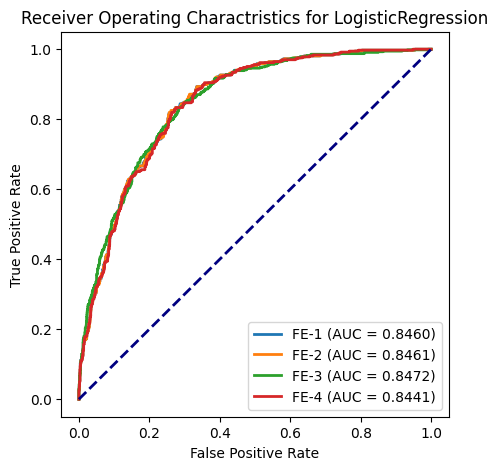

In [134]:
logreg = LogisticRegression()

datasets = {"FE-1":[X_train_OH1, X_test_OH1, y_train1, y_test1],
             "FE-2":[X_train_OH2, X_test_OH2, y_train2, y_test2],
             "FE-3":[X_train_OH3, X_test_OH3, y_train3, y_test3],
             "FE-4":[X_train_OH4, X_test_OH4, y_train4, y_test4]}

roc_auc_comparison(logreg, datasets)

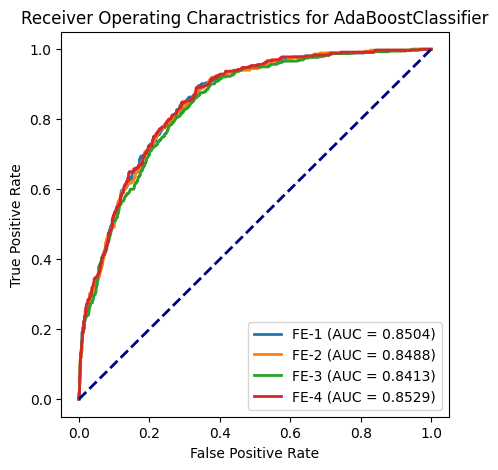

In [135]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier()

roc_auc_comparison(adaboost, datasets)

In [136]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

linear_svc = SVC(kernel='linear', probability=False)
lda = LinearDiscriminantAnalysis()

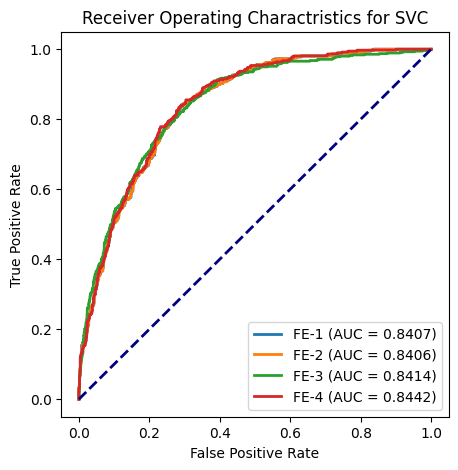

In [137]:
roc_auc_comparison(linear_svc, datasets)

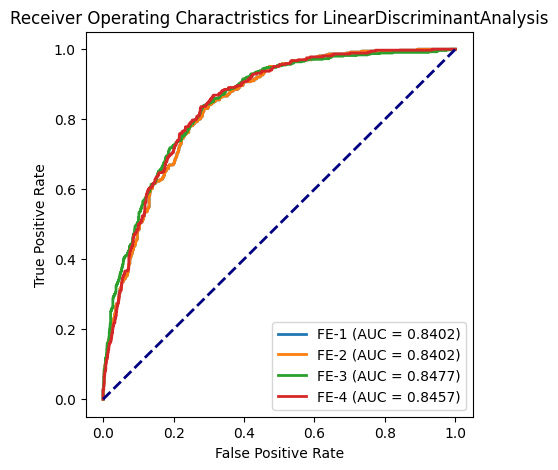

In [138]:
roc_auc_comparison(lda, datasets)

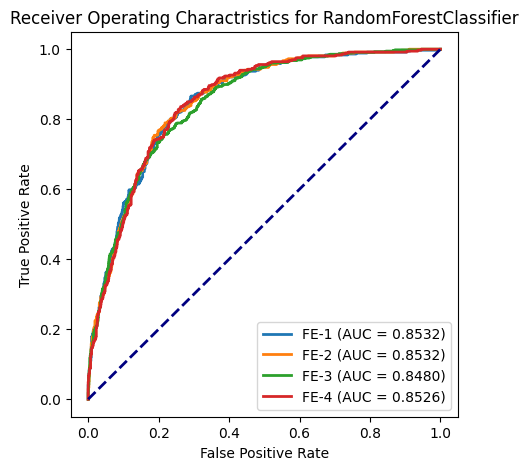

In [139]:
from sklearn.ensemble import RandomForestClassifier

rfclassifier = RandomForestClassifier(random_state = 1, max_depth=6, min_samples_leaf=7)
roc_auc_comparison(rfclassifier, datasets)

### Dataset Balancing

We can also try balancing the dataset using `SMOTE`, `SMOTEENN` and `ADASYN`

In [140]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN

smote=SMOTE(sampling_strategy='auto', random_state=1)
adasyn = ADASYN(sampling_strategy='auto', random_state=1, n_neighbors=5)
smoteenn = SMOTEENN(sampling_strategy='auto', random_state=1)

#### SMOTE

In [141]:
# Feature Engineering 1
X_train_smote1, y_train_smote1 = smote.fit_resample(X_train_OH1, y_train1)

# Feature Engineering 2
X_train_smote2, y_train_smote2 = smote.fit_resample(X_train_OH2, y_train2)

# Feature Engineering 3
X_train_smote3, y_train_smote3 = smote.fit_resample(X_train_OH3, y_train3)

# Feature Engineering 4
X_train_smote4, y_train_smote4 = smote.fit_resample(X_train_OH4, y_train4)


In [142]:
datasets2 = {"SM-1":[X_train_smote1, X_test_OH1, y_train_smote1, y_test1],
             "SM-2":[X_train_smote2, X_test_OH2, y_train_smote2, y_test2],
             "SM-3":[X_train_smote3, X_test_OH3, y_train_smote3, y_test3],
             "SM-4":[X_train_smote4, X_test_OH4, y_train_smote4, y_test4]}

In [143]:
for key, dataset in datasets2.items():
    lz_clf = LazyClassifier()
    X_train, X_test, y_train, y_test = dataset
    models, predictions = lz_clf.fit(X_train, X_test, y_train, y_test)
    display(models.sort_values(by='F1 Score', ascending=False)[:5])

100%|██████████| 29/29 [00:13<00:00,  2.10it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.78,0.72,0.72,0.78,0.50
RandomForestClassifier,0.78,0.72,0.72,0.78,0.65
SVC,0.77,0.75,0.75,0.78,1.63
LGBMClassifier,0.78,0.72,0.72,0.78,0.47
AdaBoostClassifier,0.77,0.78,0.78,0.78,0.31


100%|██████████| 29/29 [00:11<00:00,  2.61it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.78,0.73,0.73,0.79,0.61
LGBMClassifier,0.78,0.72,0.72,0.78,0.45
XGBClassifier,0.78,0.72,0.72,0.78,0.43
SVC,0.77,0.75,0.75,0.78,1.24
AdaBoostClassifier,0.77,0.77,0.77,0.78,0.22


100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NuSVC,0.78,0.75,0.75,0.79,1.46
LGBMClassifier,0.78,0.71,0.71,0.78,0.45
XGBClassifier,0.78,0.71,0.71,0.78,0.39
SVC,0.77,0.74,0.74,0.78,1.21
RandomForestClassifier,0.78,0.70,0.70,0.78,0.61


100%|██████████| 29/29 [00:10<00:00,  2.66it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.73,0.73,0.79,0.47
XGBClassifier,0.78,0.71,0.71,0.78,0.41
SVC,0.77,0.75,0.75,0.78,1.15
RandomForestClassifier,0.78,0.71,0.71,0.78,0.62
BaggingClassifier,0.78,0.71,0.71,0.78,0.17


In [144]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import NuSVC

In [145]:
logreg = LogisticRegression()
adaboost = AdaBoostClassifier()
linear_svc = SVC(kernel='linear', probability=False)
lda = LinearDiscriminantAnalysis()
rfclassifier = RandomForestClassifier(n_estimators=100, random_state = 1, max_depth=6, min_samples_leaf=7)
lgbm = LGBMClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
nu_svc = NuSVC(probability=True)

models = [logreg, adaboost, linear_svc, lda, rfclassifier, lgbm, xgb, nu_svc]

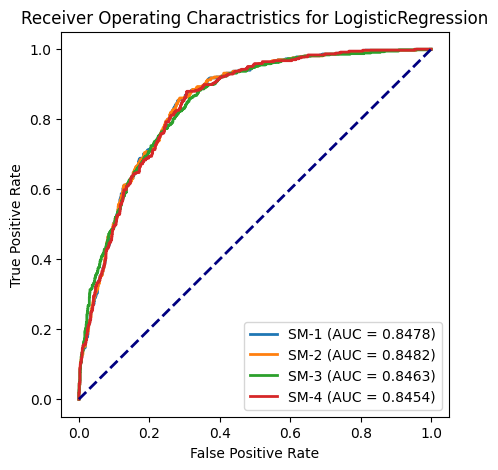

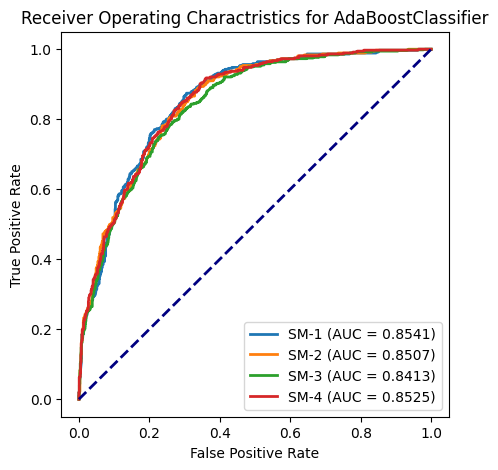

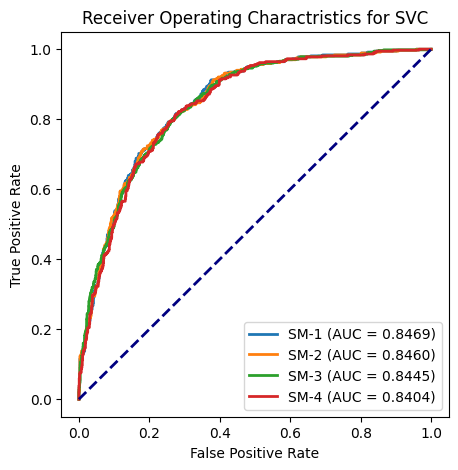

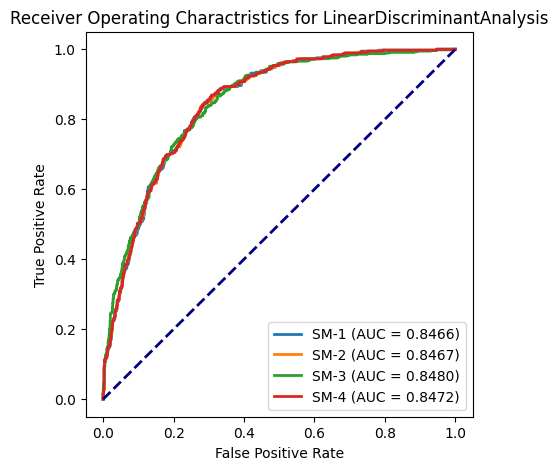

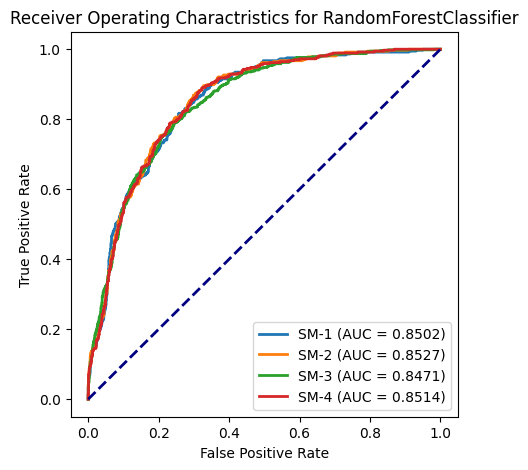

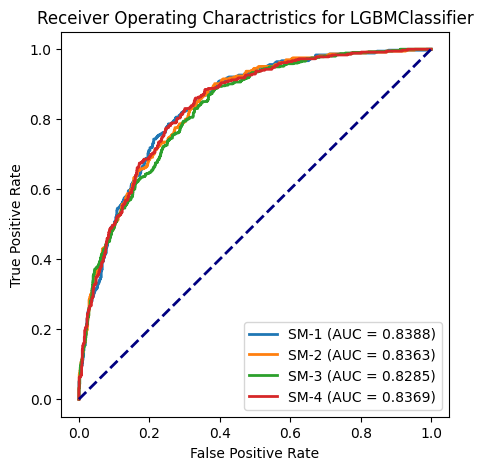

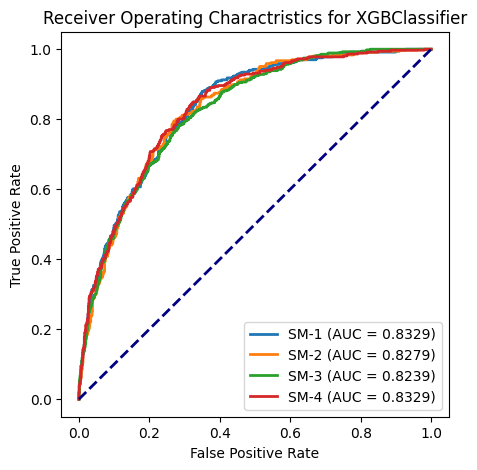

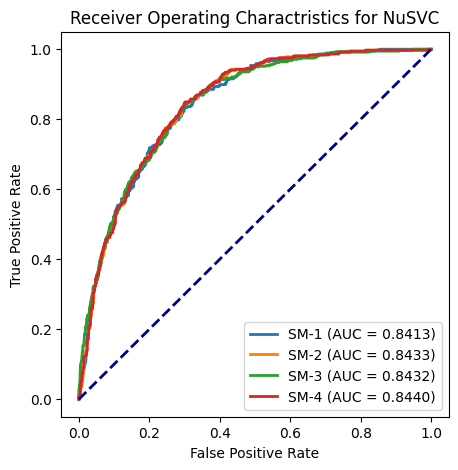

In [146]:
for model in models:
    roc_auc_comparison(model, datasets2)

#### ADASYN

100%|██████████| 29/29 [00:14<00:00,  1.99it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.78,0.71,0.71,0.78,0.47
RandomForestClassifier,0.78,0.71,0.71,0.78,0.70
XGBClassifier,0.77,0.70,0.70,0.77,0.53
AdaBoostClassifier,0.75,0.76,0.76,0.77,0.31
BaggingClassifier,0.76,0.69,0.69,0.76,0.27


100%|██████████| 29/29 [00:11<00:00,  2.61it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.72,0.72,0.79,0.46
XGBClassifier,0.78,0.72,0.72,0.78,0.41
RandomForestClassifier,0.77,0.72,0.72,0.77,0.64
NuSVC,0.76,0.76,0.76,0.77,1.54
SVC,0.76,0.76,0.76,0.77,1.21


100%|██████████| 29/29 [00:10<00:00,  2.69it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.78,0.72,0.72,0.78,0.46
RandomForestClassifier,0.77,0.70,0.70,0.77,0.56
XGBClassifier,0.77,0.70,0.70,0.77,0.36
NuSVC,0.75,0.75,0.75,0.76,1.54
ExtraTreesClassifier,0.77,0.69,0.69,0.76,0.60


100%|██████████| 29/29 [00:10<00:00,  2.65it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.78,0.72,0.72,0.78,0.45
XGBClassifier,0.78,0.71,0.71,0.78,0.37
BaggingClassifier,0.77,0.70,0.70,0.77,0.17
AdaBoostClassifier,0.76,0.77,0.77,0.77,0.19
RandomForestClassifier,0.77,0.70,0.70,0.77,0.60


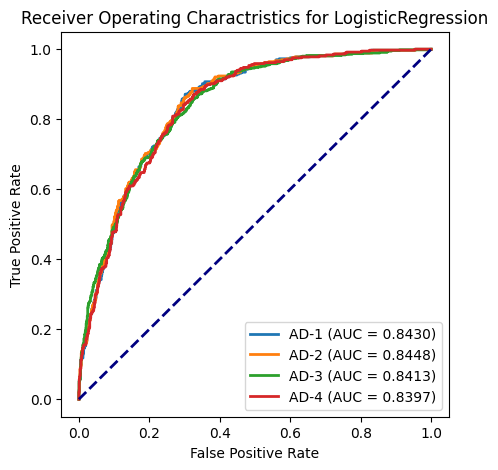

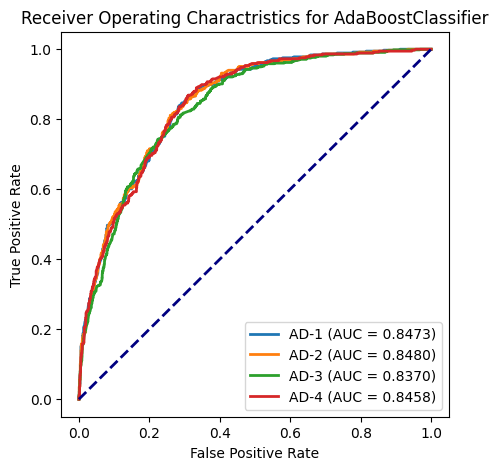

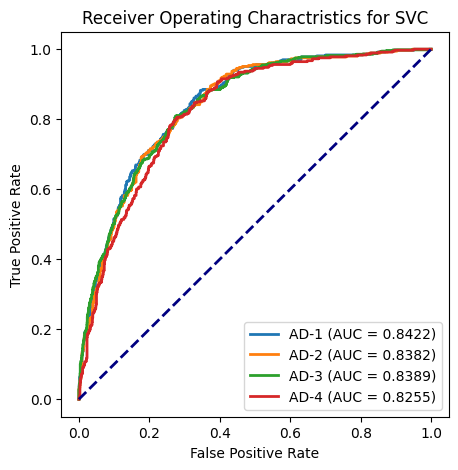

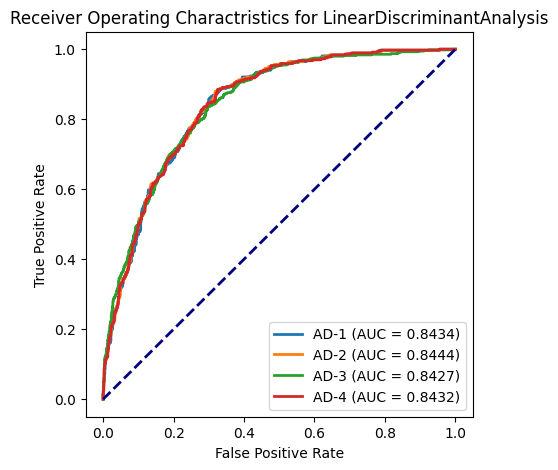

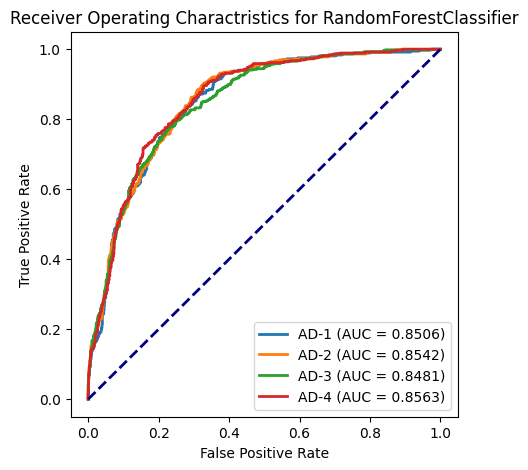

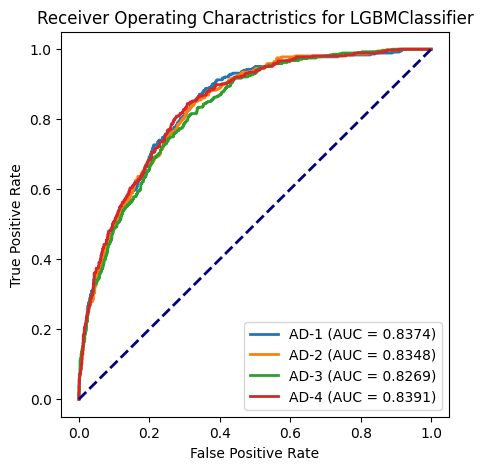

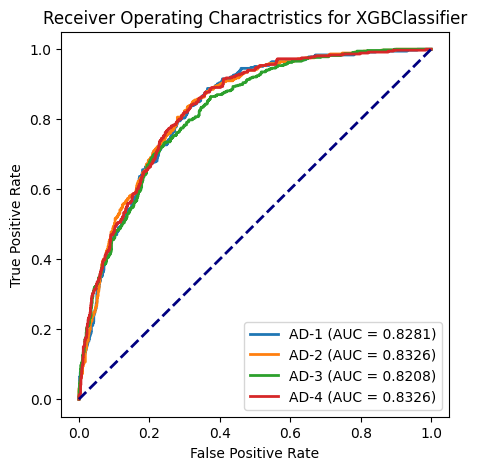

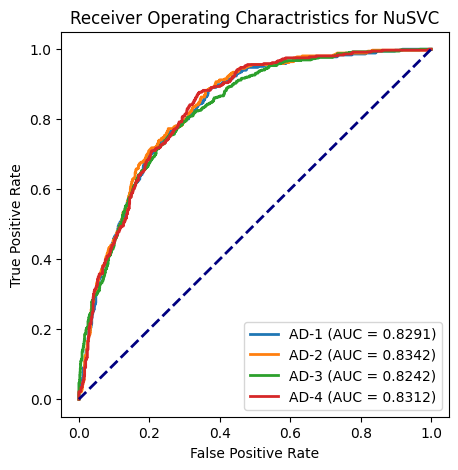

In [147]:
# Feature Engineering 1
X_train_adasyn1, y_train_adasyn1 = adasyn.fit_resample(X_train_OH1, y_train1)

# Feature Engineering 2
X_train_adasyn2, y_train_adasyn2 = adasyn.fit_resample(X_train_OH2, y_train2)

# Feature Engineering 3
X_train_adasyn3, y_train_adasyn3 = adasyn.fit_resample(X_train_OH3, y_train3)

# Feature Engineering 4
X_train_adasyn4, y_train_adasyn4 = adasyn.fit_resample(X_train_OH4, y_train4)

datasets3 = {"AD-1":[X_train_adasyn1, X_test_OH1, y_train_adasyn1, y_test1],
             "AD-2":[X_train_adasyn2, X_test_OH2, y_train_adasyn2, y_test2],
             "AD-3":[X_train_adasyn3, X_test_OH3, y_train_adasyn3, y_test3],
             "AD-4":[X_train_adasyn4, X_test_OH4, y_train_adasyn4, y_test4]}

for key, dataset in datasets3.items():
    lz_clf = LazyClassifier()
    X_train, X_test, y_train, y_test = dataset
    models, predictions = lz_clf.fit(X_train, X_test, y_train, y_test)
    display(models.sort_values(by='F1 Score', ascending=False)[:5])

models = [logreg, adaboost, linear_svc, lda, rfclassifier, lgbm, xgb, nu_svc]

for model in models:
    roc_auc_comparison(model, datasets3)

#### SMOTEENN

100%|██████████| 29/29 [00:06<00:00,  4.52it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.75,0.78,0.78,0.76,0.45
RandomForestClassifier,0.74,0.77,0.77,0.76,0.35
BaggingClassifier,0.74,0.76,0.76,0.76,0.11
XGBClassifier,0.74,0.76,0.76,0.75,0.42
ExtraTreesClassifier,0.74,0.76,0.76,0.75,0.31


100%|██████████| 29/29 [00:05<00:00,  5.21it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.75,0.77,0.77,0.76,0.36
XGBClassifier,0.74,0.76,0.76,0.76,0.28
ExtraTreesClassifier,0.74,0.76,0.76,0.75,0.30
BaggingClassifier,0.74,0.75,0.75,0.75,0.10
LGBMClassifier,0.73,0.76,0.76,0.75,0.44


100%|██████████| 29/29 [00:05<00:00,  5.27it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
RandomForestClassifier,0.74,0.76,0.76,0.75,0.33
LGBMClassifier,0.74,0.76,0.76,0.75,0.44
BaggingClassifier,0.74,0.75,0.75,0.75,0.10
QuadraticDiscriminantAnalysis,0.73,0.75,0.75,0.75,0.02
ExtraTreesClassifier,0.73,0.75,0.75,0.75,0.30


100%|██████████| 29/29 [00:05<00:00,  5.44it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
XGBClassifier,0.75,0.77,0.77,0.76,0.26
BaggingClassifier,0.74,0.75,0.75,0.76,0.08
LGBMClassifier,0.74,0.76,0.76,0.75,0.44
RandomForestClassifier,0.74,0.76,0.76,0.75,0.33
ExtraTreesClassifier,0.73,0.75,0.75,0.75,0.28


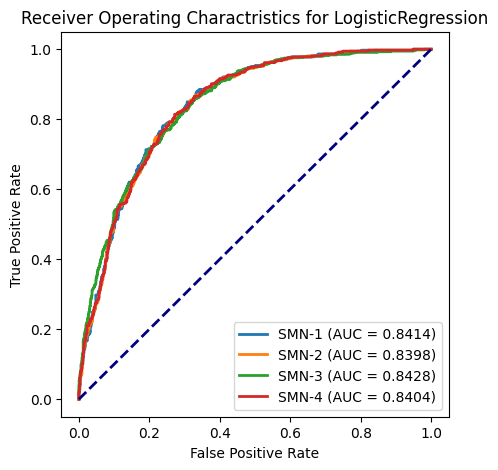

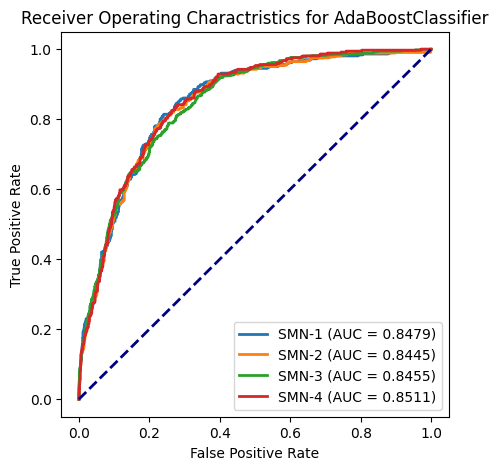

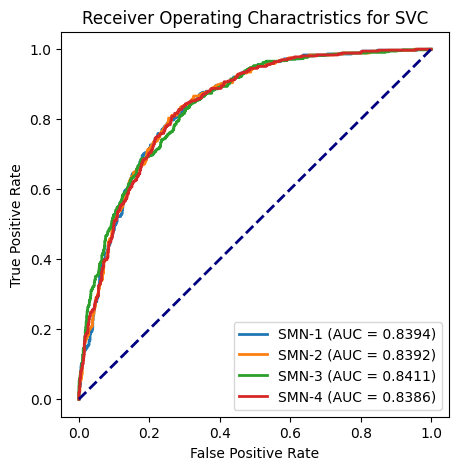

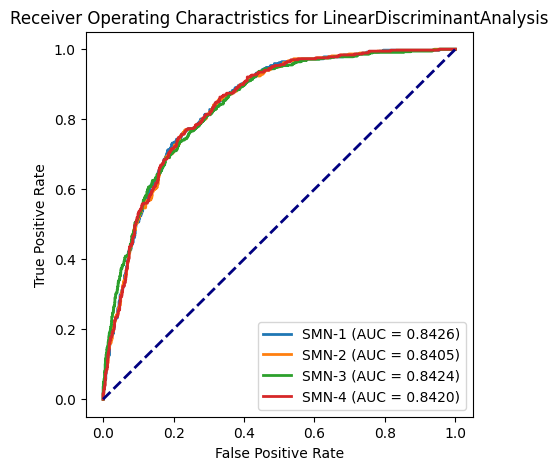

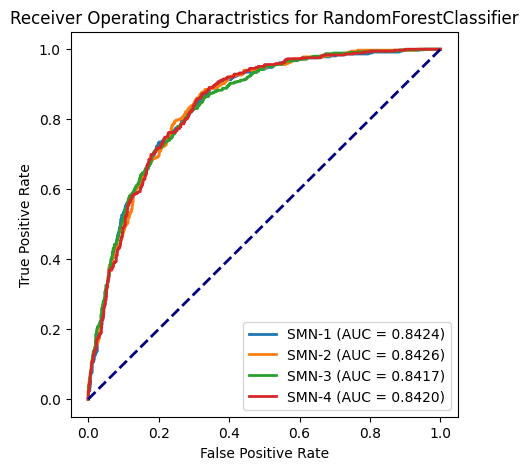

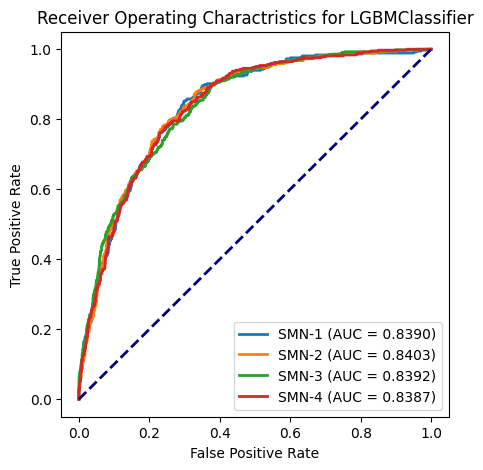

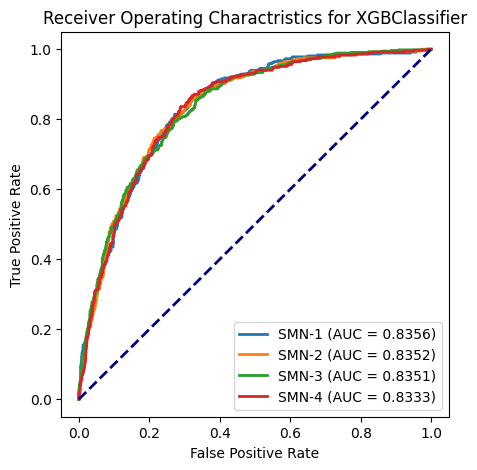

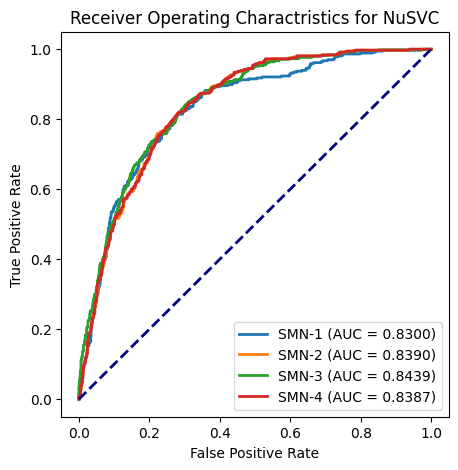

In [148]:
# Feature Engineering 1
X_train_smoteenn1, y_train_smoteenn1 = smoteenn.fit_resample(X_train_OH1, y_train1)

# Feature Engineering 2
X_train_smoteenn2, y_train_smoteenn2 = smoteenn.fit_resample(X_train_OH2, y_train2)

# Feature Engineering 3
X_train_smoteenn3, y_train_smoteenn3 = smoteenn.fit_resample(X_train_OH3, y_train3)

# Feature Engineering 4
X_train_smoteenn4, y_train_smoteenn4 = smoteenn.fit_resample(X_train_OH4, y_train4)

datasets4 = {"SMN-1":[X_train_smoteenn1, X_test_OH1, y_train_smoteenn1, y_test1],
             "SMN-2":[X_train_smoteenn2, X_test_OH2, y_train_smoteenn2, y_test2],
             "SMN-3":[X_train_smoteenn3, X_test_OH3, y_train_smoteenn3, y_test3],
             "SMN-4":[X_train_smoteenn4, X_test_OH4, y_train_smoteenn4, y_test4]}

for key, dataset in datasets4.items():
    lz_clf = LazyClassifier()
    X_train, X_test, y_train, y_test = dataset
    models, predictions = lz_clf.fit(X_train, X_test, y_train, y_test)
    display(models.sort_values(by='F1 Score', ascending=False)[:5])

models = [logreg, adaboost, linear_svc, lda, rfclassifier, lgbm, xgb, nu_svc]

for model in models:
    roc_auc_comparison(model, datasets4)

Overall We can see the best results with:

- Without dataset balancing : 

    - AdaboostClassifier performs well with Feature Engineering -4 (ROC AUC 0.8529)
    - RandomForestClassifier FE-1 and FE-2 0.8532

- Dataset Balancing with SMOTE :
    - AdaboostClassifier - FE-1 : 0.8541 and FE-4 :0.8525
    - RandomForestClassifier - FE-2 : 0.8527

- Dataset Balancing with ADASYN :
    - RandomForestClassifier - FE-2 : 0.8542 and FE-4 : 0.8563

- Dataset Balancing with SMOTEENN :
    - AdaboostClassifier - FE-4 : 0.8511

It should be noted that RandomForestClassifier was tested with a basic hyperaparameter tuning.

From LazyPredict we get the following

- Without dataset balancing : AdaboostClassifier performs the best with FE-4

- Dataset Balancing with SMOTE : RandomForestClassifier performs well with FE-2 and LightGBM with FE-4

- Dataset Balancing with ADASYN : LightGBM with FE-2

- Dataset Balancing with SMOTEENN : LightGBM with FE-1

We can focus on AdaBoostClassifier, RandomForestRegressor and LightGBM and check if we can get a higher performance with hyperaparameter tuning

### Hyperparameter Tuning

We can select the feature engineering where each of these models perform well and focus on tuning for those.

In [149]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, classification_report, confusion_matrix, recall_score

In [150]:
def  grid_search_with_datsets(model, param_grid, datasets):
    results = {}
    for key, dataset in datasets.items():
        X_train, X_test, y_train, y_test = dataset

        scoring = {
            'F1_Score' : make_scorer(f1_score),
            'ROC_AUC' : make_scorer(roc_auc_score),
            'Recall': make_scorer(recall_score)
        }

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='F1_Score')

        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)

        report = classification_report(y_test, y_pred)

        conf_matrix = confusion_matrix(y_test, y_pred)

        results[key]={
            'best_parameters' : grid_search.best_params_,
            'classification_report' : report,
            'confusion_matrix' : conf_matrix            
        }

    return results

#### AdaBoostClassifier

In [151]:
datasets_ada = {"IMB_FE4": [X_train_OH4, X_test_OH4, y_train4, y_test4],
           "SMT_FE1": [X_train_smote1, X_test_OH1, y_train_smote1, y_test1],
           "SMT_FE4": [X_train_smote4, X_test_OH4, y_train_smote4, y_test4],
           "SMN_FE4": [X_train_smoteenn4, X_test_OH4, y_train_smoteenn4, y_test4]
           }

param_grid_ada = {
    'n_estimators' : [150, 250],
    'learning_rate' : [1.3]
}

model_ada = AdaBoostClassifier()

In [152]:
# # Code commented as it takes a long time to run

# results = grid_search_with_datsets(model_ada, param_grid_ada, datasets_ada)

# for key, result in results.items():
#     print(f"Dataset : {key}")
#     print("Best Parameter :")
#     print(result['best_parameters'])
#     print("\n Classification Report:")
#     print(result['classification_report'])
#     print("\n Confusion Matrix:")
#     print(result['confusion_matrix'])
#     print("\n\n")

In [153]:
# # OUTPUT:
'''
Dataset : IMB_FE4
Best Parameter :
{'learning_rate': 1.3, 'n_estimators': 150}

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1041
           1       0.62      0.52      0.57       366

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.72      1407
weighted avg       0.78      0.79      0.79      1407


 Confusion Matrix:

[[927 114]

 [176 190]]



Dataset : SMT_FE1
Best Parameter :
{'learning_rate': 1.3, 'n_estimators': 150}

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1041
           1       0.57      0.71      0.63       366

    accuracy                           0.78      1407
   macro avg       0.73      0.76      0.74      1407
weighted avg       0.80      0.78      0.79      1407


 Confusion Matrix:

[[844 197]

 [107 259]]



Dataset : SMT_FE4
Best Parameter :
{'learning_rate': 1.3, 'n_estimators': 150}

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1041
           1       0.59      0.72      0.65       366

    accuracy                           0.80      1407
   macro avg       0.74      0.77      0.76      1407
weighted avg       0.82      0.80      0.81      1407


 Confusion Matrix:

[[861 180]

 [102 264]]



Dataset : SMN_FE4
Best Parameter :
{'learning_rate': 1.3, 'n_estimators': 150}

 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.69      0.79      1041
           1       0.49      0.87      0.63       366

    accuracy                           0.73      1407
   macro avg       0.71      0.78      0.71      1407
weighted avg       0.82      0.73      0.75      1407


 Confusion Matrix:
 
[[714 327]

 [ 49 317]]

 '''


"\nDataset : IMB_FE4\nBest Parameter :\n{'learning_rate': 1.3, 'n_estimators': 150}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.84      0.89      0.86      1041\n           1       0.62      0.52      0.57       366\n\n    accuracy                           0.79      1407\n   macro avg       0.73      0.70      0.72      1407\nweighted avg       0.78      0.79      0.79      1407\n\n\n Confusion Matrix:\n\n[[927 114]\n\n [176 190]]\n\n\n\nDataset : SMT_FE1\nBest Parameter :\n{'learning_rate': 1.3, 'n_estimators': 150}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.89      0.81      0.85      1041\n           1       0.57      0.71      0.63       366\n\n    accuracy                           0.78      1407\n   macro avg       0.73      0.76      0.74      1407\nweighted avg       0.80      0.78      0.79      1407\n\n\n Confusion Matrix:\n\n[[844 197]\n\n [107 259]]\

#### RandomForestClassifier

In [154]:
datasets_rfc = {"IMB_FE1": [X_train_OH1, X_test_OH1, y_train1, y_test1]}

param_grid_rfc= {
    'n_estimators' : [100],
    'max_depth': [10, 12, 14]}

model_rfc = RandomForestClassifier()

In [155]:
# # Code commented as it takes a long time to run

# results = grid_search_with_datsets(model_rfc, param_grid_rfc, datasets_rfc)

# for key, result in results.items():
#     print(f"Dataset : {key}")
#     print("Best Parameter :")
#     print(result['best_parameters'])
#     print("\n Classification Report:")
#     print(result['classification_report'])
#     print("\n Confusion Matrix:")
#     print(result['confusion_matrix'])
#     print("\n\n")

In [156]:
# # OUTPUT:

'''
Dataset : IMB_FE1
Best Parameter :
{'max_depth': 12, 'n_estimators': 100}

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1041
           1       0.63      0.50      0.56       366

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


 Confusion Matrix:

[[933 108]

 [183 183]]

'''

"\nDataset : IMB_FE1\nBest Parameter :\n{'max_depth': 12, 'n_estimators': 100}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.84      0.90      0.87      1041\n           1       0.63      0.50      0.56       366\n\n    accuracy                           0.79      1407\n   macro avg       0.73      0.70      0.71      1407\nweighted avg       0.78      0.79      0.78      1407\n\n\n Confusion Matrix:\n\n[[933 108]\n\n [183 183]]\n\n"

In [157]:
datasets_rfc = {"IMB_FE2": [X_train_OH2, X_test_OH2, y_train2, y_test2],
                "SMT_FE2": [X_train_smote2, X_test_OH2, y_train_smote2, y_test2],
                "ADN_FE2": [X_train_adasyn2, X_test_OH2, y_train_adasyn2, y_test2],
                "ADN_FE4": [X_train_adasyn4, X_test_OH4, y_train_adasyn4, y_test4],
                #"SMN_FE2": [X_train_smoteenn1, X_test_OH1, y_train_smoteenn1, y_test1], #Just for reference
                }

param_grid_rfc= {
    'n_estimators' : [250, 350, 400, 450],
    'max_depth': [10, 18, 22, 24]}

model_rfc = RandomForestClassifier()

In [158]:
# # Code commented as it takes a long time to run

# results = grid_search_with_datsets(model_rfc, param_grid_rfc, datasets_rfc)

# for key, result in results.items():
#     print(f"Dataset : {key}")
#     print("Best Parameter :")
#     print(result['best_parameters'])
#     print("\n Classification Report:")
#     print(result['classification_report'])
#     print("\n Confusion Matrix:")
#     print(result['confusion_matrix'])
#     print("\n\n")

In [159]:
# # OUTPUT :

'''
Dataset : IMB_FE2
Best Parameter :
{'max_depth': 10, 'n_estimators': 350}

 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1041
           1       0.65      0.48      0.55       366

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.79      0.80      0.79      1407


 Confusion Matrix:

[[946  95]

 [189 177]]



Dataset : SMT_FE2
Best Parameter :
{'max_depth': 18, 'n_estimators': 450}

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1041
           1       0.57      0.62      0.59       366

    accuracy                           0.78      1407
   macro avg       0.72      0.73      0.72      1407
weighted avg       0.79      0.78      0.78      1407


 Confusion Matrix:

[[869 172]

 [139 227]]



Dataset : ADN_FE2
Best Parameter :
{'max_depth': 18, 'n_estimators': 400}

 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1041
           1       0.56      0.66      0.61       366

    accuracy                           0.78      1407
   macro avg       0.72      0.74      0.72      1407
weighted avg       0.79      0.78      0.78      1407


 Confusion Matrix:

[[852 189]

 [125 241]]



Dataset : ADN_FE4
Best Parameter :
{'max_depth': 18, 'n_estimators': 350}

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1041
           1       0.56      0.63      0.59       366

    accuracy                           0.78      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.78      0.78      1407


 Confusion Matrix:

[[863 178]

 [137 229]]

'''

"\nDataset : IMB_FE2\nBest Parameter :\n{'max_depth': 10, 'n_estimators': 350}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.83      0.91      0.87      1041\n           1       0.65      0.48      0.55       366\n\n    accuracy                           0.80      1407\n   macro avg       0.74      0.70      0.71      1407\nweighted avg       0.79      0.80      0.79      1407\n\n\n Confusion Matrix:\n\n[[946  95]\n\n [189 177]]\n\n\n\nDataset : SMT_FE2\nBest Parameter :\n{'max_depth': 18, 'n_estimators': 450}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.86      0.83      0.85      1041\n           1       0.57      0.62      0.59       366\n\n    accuracy                           0.78      1407\n   macro avg       0.72      0.73      0.72      1407\nweighted avg       0.79      0.78      0.78      1407\n\n\n Confusion Matrix:\n\n[[869 172]\n\n [139 227]]\n\n\n\nDat

#### LightGBM

In [160]:
datasets_lgb = {"IMB_FE1": [X_train_OH1, X_test_OH1, y_train1, y_test1],
                "IMB_FE2": [X_train_OH2, X_test_OH2, y_train2, y_test2],
                "SMT_FE2": [X_train_smote2, X_test_OH2, y_train_smote2, y_test2],
                "SMT_FE4": [X_train_smote4, X_test_OH4, y_train_smote4, y_test4],
                "ADN_FE2": [X_train_adasyn2, X_test_OH2, y_train_adasyn2, y_test2],
                "SMN_FE1": [X_train_smoteenn1, X_test_OH1, y_train_smoteenn1, y_test1]
                }

param_grid_lgb= {
        'num_leaves': [10, 25, 30, 35],
        'learning_rate': [0.03, 0.1, 0.3, 1],
        'n_estimators': [25, 50, 100, 150, 200]
}

model_lgb = LGBMClassifier()

In [161]:
# # Code commented as it takes a long time to run

# results = grid_search_with_datsets(model_lgb, param_grid_lgb, datasets_lgb)

# for key, result in results.items():
#     print(f"Dataset : {key}")
#     print("Best Parameter :")
#     print(result['best_parameters'])
#     print("\n Classification Report:")
#     print(result['classification_report'])
#     print("\n Confusion Matrix:")
#     print(result['confusion_matrix'])
#     print("\n\n")


In [162]:
# # OUTPUT :
'''
Dataset : IMB_FE1
Best Parameter :
{'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 25}

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1041
           1       0.63      0.50      0.56       366

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.79      1407


 Confusion Matrix:

[[935 106]

 [183 183]]



Dataset : IMB_FE2
Best Parameter :
{'learning_rate': 1, 'n_estimators': 150, 'num_leaves': 25}

 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1041
           1       0.51      0.51      0.51       366

    accuracy                           0.75      1407
   macro avg       0.67      0.67      0.67      1407
weighted avg       0.75      0.75      0.75      1407


 Confusion Matrix:

[[863 178]

 [178 188]]



Dataset : SMT_FE2
Best Parameter :
{'learning_rate': 0.03, 'n_estimators': 200, 'num_leaves': 10}

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1041
           1       0.58      0.71      0.63       366

    accuracy                           0.79      1407
   macro avg       0.73      0.76      0.74      1407
weighted avg       0.81      0.79      0.79      1407


 Confusion Matrix:

[[850 191]

 [107 259]]



Dataset : SMT_FE4
Best Parameter :
{'learning_rate': 0.03, 'n_estimators': 200, 'num_leaves': 10}

 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1041
           1       0.57      0.70      0.63       366

    accuracy                           0.78      1407
   macro avg       0.73      0.76      0.74      1407
weighted avg       0.80      0.78      0.79      1407


 Confusion Matrix:

[[849 192]

 [111 255]]



Dataset : ADN_FE2
Best Parameter :
{'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 10}

 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1041
           1       0.55      0.74      0.63       366

    accuracy                           0.78      1407
   macro avg       0.72      0.76      0.74      1407
weighted avg       0.81      0.78      0.79      1407


 Confusion Matrix:

[[821 220]

 [ 95 271]]



Dataset : SMN_FE1
Best Parameter :
{'learning_rate': 0.3, 'n_estimators': 200, 'num_leaves': 35}

 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1041
           1       0.50      0.81      0.62       366

    accuracy                           0.74      1407
   macro avg       0.71      0.77      0.71      1407
weighted avg       0.81      0.74      0.76      1407


 Confusion Matrix:

[[748 293]

 [ 69 297]]

'''

"\nDataset : IMB_FE1\nBest Parameter :\n{'learning_rate': 0.1, 'n_estimators': 150, 'num_leaves': 25}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.84      0.90      0.87      1041\n           1       0.63      0.50      0.56       366\n\n    accuracy                           0.79      1407\n   macro avg       0.73      0.70      0.71      1407\nweighted avg       0.78      0.79      0.79      1407\n\n\n Confusion Matrix:\n\n[[935 106]\n\n [183 183]]\n\n\n\nDataset : IMB_FE2\nBest Parameter :\n{'learning_rate': 1, 'n_estimators': 150, 'num_leaves': 25}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.83      0.83      0.83      1041\n           1       0.51      0.51      0.51       366\n\n    accuracy                           0.75      1407\n   macro avg       0.67      0.67      0.67      1407\nweighted avg       0.75      0.75      0.75      1407\n\n\n Confusion Mat

Based on all the above combination of `AdaBoostClassifier` for dataset with `SMOTE` Dataset Balancing and 'Feature Engineering 4' which was `TotalCharges` removed, gave a comparitively good trade-ff betwee Recall and Precision.

#### Re-test AdaBoostClassifier

We Test the classifier again on all datsets to confirm the performance.

We can focus on AdaBoostClassifier and try to tune further

In [163]:
def  grid_search2(model, param_grid, datasets, refit):
    results = {}
    for key, dataset in datasets.items():
        X_train, X_test, y_train, y_test = dataset

        scoring = {
            'F1_Score' : make_scorer(f1_score),
            'ROC_AUC' : make_scorer(roc_auc_score),
            'Recall': make_scorer(recall_score)
        }

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit=refit)

        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test)

        report = classification_report(y_test, y_pred)

        conf_matrix = confusion_matrix(y_test, y_pred)

        results[key]={
            'best_parameters' : grid_search.best_params_,
            'classification_report' : report,
            'confusion_matrix' : conf_matrix            
        }

    return results

In [164]:
# # Code commented as it takes a long time to run

# datasets_ada = {
#                 "SMT_FE4": [X_train_smote4, X_test_OH4, y_train_smote4, y_test4]
#            }

# param_grid_ada = {
#     'n_estimators' : [100, 125, 150, 175, 200],
#     'learning_rate' : [0.67, 1, 1.32, 1.67, 2]
# }

# model_ada = AdaBoostClassifier()

# refit = 'Recall'

# results = grid_search2(model_ada, param_grid_ada, datasets_ada, refit)

# for key, result in results.items():
#     print(f"Dataset : {key}")
#     print("Best Parameter :")
#     print(result['best_parameters'])
#     print("\n Classification Report:")
#     print(result['classification_report'])
#     print("\n Confusion Matrix:")
#     print(result['confusion_matrix'])
#     print("\n\n")



In [165]:
# # OUTPUT : 
'''
Dataset : SMT_FE4
Best Parameter :
{'learning_rate': 2, 'n_estimators': 125}

 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.31      0.47      1041
           1       0.33      0.98      0.50       366

    accuracy                           0.48      1407
   macro avg       0.65      0.64      0.48      1407
weighted avg       0.81      0.48      0.48      1407


 Confusion Matrix:
[[325 716]
 [  9 357]]

'''

"\nDataset : SMT_FE4\nBest Parameter :\n{'learning_rate': 2, 'n_estimators': 125}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.97      0.31      0.47      1041\n           1       0.33      0.98      0.50       366\n\n    accuracy                           0.48      1407\n   macro avg       0.65      0.64      0.48      1407\nweighted avg       0.81      0.48      0.48      1407\n\n\n Confusion Matrix:\n[[325 716]\n [  9 357]]\n\n"

In [166]:
# # Code commented as it takes a long time to run

# datasets_ada = {
#                 "SMT_FE4": [X_train_smote4, X_test_OH4, y_train_smote4, y_test4]
#            }

# param_grid_ada = {
#     'n_estimators' : [100, 125, 150, 175, 200],
#     'learning_rate' : [0.67, 1, 1.32, 1.67, 2]
# }

# model_ada = AdaBoostClassifier()

# refit = 'F1_Score'

# results = grid_search2(model_ada, param_grid_ada, datasets_ada, refit)

# for key, result in results.items():
#     print(f"Dataset : {key}")
#     print("Best Parameter :")
#     print(result['best_parameters'])
#     print("\n Classification Report:")
#     print(result['classification_report'])
#     print("\n Confusion Matrix:")
#     print(result['confusion_matrix'])
#     print("\n\n")

In [167]:
# # OUTPUT :

'''
Dataset : SMT_FE4

Best Parameter :

{'learning_rate': 1.32, 'n_estimators': 200}

 Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1041
           
           1       0.59      0.70      0.64       366

    accuracy                           0.80      1407

   macro avg       0.74      0.77      0.75      1407

weighted avg       0.81      0.80      0.80      1407


 Confusion Matrix:

[[863 178]

 [108 258]]

'''

"\nDataset : SMT_FE4\n\nBest Parameter :\n\n{'learning_rate': 1.32, 'n_estimators': 200}\n\n Classification Report:\n\n              precision    recall  f1-score   support\n\n           0       0.89      0.83      0.86      1041\n           \n           1       0.59      0.70      0.64       366\n\n    accuracy                           0.80      1407\n\n   macro avg       0.74      0.77      0.75      1407\n\nweighted avg       0.81      0.80      0.80      1407\n\n\n Confusion Matrix:\n\n[[863 178]\n\n [108 258]]\n\n"

In [168]:
# # Code commented as it takes a long time to run

# datasets_ada = {
#                 "SMT_FE4": [X_train_smote4, X_test_OH4, y_train_smote4, y_test4]
#            }

# param_grid_ada = {
#     'n_estimators' : [100, 125, 150, 175, 200],
#     'learning_rate' : [0.67, 1, 1.32, 1.67, 2]
# }

# model_ada = AdaBoostClassifier()

# refit = 'ROC_AUC'

# results = grid_search2(model_ada, param_grid_ada, datasets_ada, refit)

# for key, result in results.items():
#     print(f"Dataset : {key}")
#     print("Best Parameter :")
#     print(result['best_parameters'])
#     print("\n Classification Report:")
#     print(result['classification_report'])
#     print("\n Confusion Matrix:")
#     print(result['confusion_matrix'])
#     print("\n\n")

In [169]:
# # OUTPUT: 
'''
Dataset : SMT_FE4
Best Parameter :
{'learning_rate': 1.32, 'n_estimators': 200}

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1041
           1       0.59      0.70      0.64       366

    accuracy                           0.80      1407
   macro avg       0.74      0.77      0.75      1407
weighted avg       0.81      0.80      0.80      1407


 Confusion Matrix:
[[863 178]
 [108 258]]
'''

"\nDataset : SMT_FE4\nBest Parameter :\n{'learning_rate': 1.32, 'n_estimators': 200}\n\n Classification Report:\n              precision    recall  f1-score   support\n\n           0       0.89      0.83      0.86      1041\n           1       0.59      0.70      0.64       366\n\n    accuracy                           0.80      1407\n   macro avg       0.74      0.77      0.75      1407\nweighted avg       0.81      0.80      0.80      1407\n\n\n Confusion Matrix:\n[[863 178]\n [108 258]]\n"

In [170]:
datasets_ada = {
                "SMT_FE4": [X_train_smote4, X_test_OH4, y_train_smote4, y_test4]
           }

param_grid_ada = {
    'n_estimators' : [250],
    'learning_rate' : [1.3]
}

model_ada = AdaBoostClassifier()

refit = 'F1_Score'

results = grid_search2(model_ada, param_grid_ada, datasets_ada, refit)

for key, result in results.items():
    print(f"Dataset : {key}")
    print("Best Parameter :")
    print(result['best_parameters'])
    print("\n Classification Report:")
    print(result['classification_report'])
    print("\n Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\n\n")

Dataset : SMT_FE4
Best Parameter :
{'learning_rate': 1.3, 'n_estimators': 250}

 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1041
           1       0.60      0.70      0.65       366

    accuracy                           0.80      1407
   macro avg       0.74      0.77      0.75      1407
weighted avg       0.81      0.80      0.81      1407


 Confusion Matrix:
[[869 172]
 [108 258]]





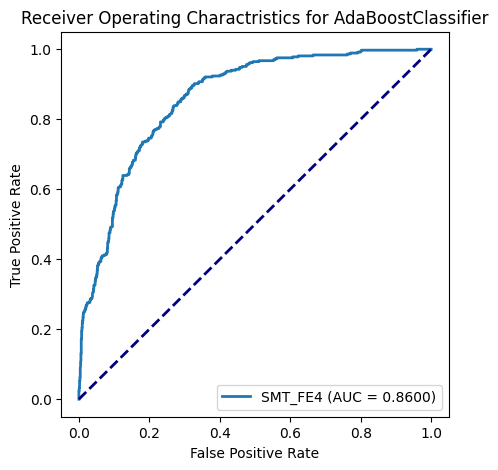

In [171]:
roc_auc_comparison(AdaBoostClassifier(n_estimators=250, learning_rate=1.3), datasets_ada)

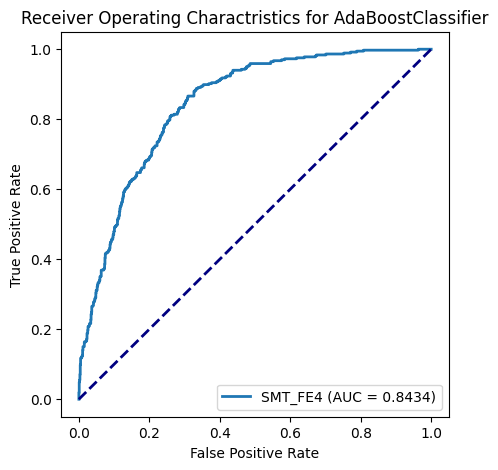

In [172]:
roc_auc_comparison(AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=250, learning_rate=1.3), datasets_ada)

Since `AdaBoostClassifier` is a tree based model, multicollinearity shouldn't really affect it. But we hav seen improved performance in AdaBoostClassifier by removing `TotalCharges` which we considered to be a product of `tenure` and `MonthlyCharges`.

We had also removed 'No Internet Service' observation in multiple features which was redundant, although the performance improvement was small.

We were comparing with multiple models earlier. Since we are now working solely with `AdaBoostClassifier`, we can try out some other combinations of features as well. 

- We can try having tenure-ranges instead of tenure along with `MonthlyCharges` . We can try with and without `TotalCharges` as well.
- We can try avoiding scaling of number values

In [212]:
X5 = data.copy().drop('Churn', axis=1)

drop_cols = ['PhoneService',
             'TotalCharges'
             ]

X5.drop(drop_cols, axis=1, inplace=True)
for col in internet_feats[1:]:
    X5[col] = X5[col].replace({'No internet service':'No'})

# tenure_bins=12
# bin_size = int(X5['tenure'].max()/tenure_bins)
# labels = ['{}-{}'.format(i, i+bin_size-1) for i in range(1,X5['tenure'].max(), bin_size)]
# X5['tenure_range']=pd.cut(X5['tenure'], bins=range(1,X5['tenure'].max()+bin_size,bin_size), right=False, labels=labels) # Add tenure Ranges 

# X5.drop('tenure', axis=1, inplace=True) # Remove tenure

cat_columns = X5.select_dtypes(exclude='number').columns
num_columns = X5.select_dtypes(include='number').columns
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y, test_size=0.2, random_state=1)

cat_columns1 = ['gender', 'PaymentMethod', 'MultipleLines', 'Contract',  # We can drop the first column for these features
                # 'tenure_range'
                ]
cat_columns2 = cat_columns.drop(cat_columns1) #All these features have a 'No' value which we can target and make 0
drop_no = ['No'] * len(cat_columns2)

transformer = [('OH1', OneHotEncoder(sparse_output=False, drop='first'), cat_columns1), # One-Hot Encode and drop first column
               ('OH2', OneHotEncoder(sparse_output=False, drop=drop_no), cat_columns2), # One-Hot Encode and drop 'No' value features
            #  ('scaler', MinMaxScaler(), num_columns), # Scale Numerical columns to lie between 0 and 1
              ('passthrough', 'passthrough', num_columns), # Passthrough Numerical features without transforming
               ]
preprocessor = ColumnTransformer(transformer)

X_train_OH5 = preprocessor.fit_transform(X_train5)
X_test_OH5 = preprocessor.transform(X_test5)

X_train_OH5 = pd.DataFrame(X_train_OH5)
X_test_OH5 = pd.DataFrame(X_test_OH5)

X_train_smote5, y_train_smote5 = smote.fit_resample(X_train_OH5, y_train5)

In [213]:
dataset_5 = {
                "SMT_FE5": [X_train_smote5, X_test_OH5, y_train_smote5, y_test5]
           }

param_grid_5 = {
    'n_estimators' : [250],
    'learning_rate' : [1.3]
}

model_5 = AdaBoostClassifier()

refit = 'F1_Score'

results = grid_search2(model_5, param_grid_5, dataset_5, refit)

for key, result in results.items():
    print(f"Dataset : {key}")
    print("Best Parameter :")
    print(result['best_parameters'])
    print("\n Classification Report:")
    print(result['classification_report'])
    print("\n Confusion Matrix:")
    print(result['confusion_matrix'])
    print("\n\n")

Dataset : SMT_FE5
Best Parameter :
{'learning_rate': 1.3, 'n_estimators': 250}

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1041
           1       0.63      0.60      0.62       366

    accuracy                           0.80      1407
   macro avg       0.75      0.74      0.74      1407
weighted avg       0.80      0.80      0.80      1407


 Confusion Matrix:
[[912 129]
 [146 220]]





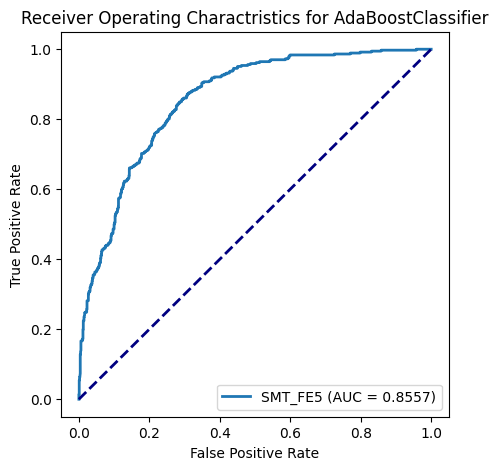

In [214]:
roc_auc_comparison(AdaBoostClassifier(n_estimators=250, learning_rate=1.3), dataset_5)

The different combinations were tried out and there was no improvment in perfomrnace, compared to SMT-FE4

### Model Selection Conclusion

In conclusion the model we will be using to predict Churn will be an `AdaBostClassifier` with the following hyperparameters:

`n_estimators`  = 250

`learning_rate` = 1.3

The following feature engineering will be performed:
- `PhoneService` might be dropped and `MultipleLines` which already captures the information will be One-Hot Encoded
- `InternetService` will be One-Hot Encoded and the 'No Internet Service' observation in `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` & `StreamingMovies` will all be changed to 'No', same as if they had Internet Service and didn't use the service. The reason being that `InternetService` will show if they had Internet Service.
- All other categorical features will be One-Hot ENcoded and the 'first' column will be dropped to avoid Multicollinearity. Since, AdaBoostClassifier is tree based multi-collinearity doest't really affect it, but it reduces computation time as the number of features is reduced.
- Wherever the features recored Boolean obseravtion as 'Yes' or 'No', we set 'No' to zero.
- The `TotalCharges` feature is approximately equal to the product of `tenure` and `MonthlyCharges`. So, we remove the 'TotalCharges' feature. This again is more important in Linear models but we have seen increased performance in AdaBoostClassifier with this strategy.
- The dataset will be balanced using `SMOTE`
